# Understanding the Data 




In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import sklearn
from sklearn.model_selection import GridSearchCV

# !pip install sklearn_crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

In [2]:
data_features=pd.read_csv('ner.csv',encoding="ISO-8859-1" ,error_bad_lines=False)
data=pd.read_csv("ner_dataset.csv",encoding="ISO-8859-1")

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
Sentence #    47959 non-null object
Word          1048575 non-null object
POS           1048575 non-null object
Tag           1048575 non-null object
dtypes: object(4)
memory usage: 32.0+ MB


In [4]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 25 columns):
Unnamed: 0         1050795 non-null int64
lemma              1050795 non-null object
next-lemma         1050795 non-null object
next-next-lemma    1050795 non-null object
next-next-pos      1050795 non-null object
next-next-shape    1050795 non-null object
next-next-word     1050795 non-null object
next-pos           1050795 non-null object
next-shape         1050794 non-null object
next-word          1050794 non-null object
pos                1050794 non-null object
prev-iob           1050794 non-null object
prev-lemma         1050794 non-null object
prev-pos           1050794 non-null object
prev-prev-iob      1050794 non-null object
prev-prev-lemma    1050794 non-null object
prev-prev-pos      1050794 non-null object
prev-prev-shape    1050794 non-null object
prev-prev-word     1050794 non-null object
prev-shape         1050794 non-null object
prev-word          1050794 n

In [5]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
data.columns=['Sentence', 'Word', 'POS', 'Tag']


In [7]:
data.Sentence.fillna(method="pad",inplace=True)

In [8]:
data.Sentence=data.Sentence.apply(lambda x: x[10:]).astype(int)

In [9]:
data.Sentence.max()

47959

In [10]:
# there are 47959 sentences in total

In [11]:
def preprocess_data():
    dataset=[]
    X=[]
    y=[]
    for index in range(1,data.Sentence.max()+1):
        sentence=data[data.Sentence == index]
        dataset.append(list(zip(sentence.Word.values,sentence.POS.values,sentence.Tag.values)))
        X.append(list(zip(sentence.Word.values,sentence.POS.values)))
        y.append(list(sentence.Tag.values))
    return dataset,X,y

In [12]:
dataset,X,y=preprocess_data()

In [13]:
X[0],y[0]
# dataset[:20]

([('Thousands', 'NNS'),
  ('of', 'IN'),
  ('demonstrators', 'NNS'),
  ('have', 'VBP'),
  ('marched', 'VBN'),
  ('through', 'IN'),
  ('London', 'NNP'),
  ('to', 'TO'),
  ('protest', 'VB'),
  ('the', 'DT'),
  ('war', 'NN'),
  ('in', 'IN'),
  ('Iraq', 'NNP'),
  ('and', 'CC'),
  ('demand', 'VB'),
  ('the', 'DT'),
  ('withdrawal', 'NN'),
  ('of', 'IN'),
  ('British', 'JJ'),
  ('troops', 'NNS'),
  ('from', 'IN'),
  ('that', 'DT'),
  ('country', 'NN'),
  ('.', '.')],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
len(X_train),len(X_test)

(33571, 14388)

In [16]:
# extracts features for the word at index i in a sentence 
def word_features(sentence):
    features=[]
    for i in range(0, len(sentence)):
        word,pos=sentence[i]
        word_pos=i
        # first word
        if i==0:
            prevword = '<START>'
            prevpos = '<START>'
        else:
            prevword = sentence[i-1][0]
            prevpos = sentence[i-1][1]

        # last word
        if i == len(sentence)-1:
            nextword = '<END>'
            nextpos = '<END>'
        else:
            nextword = sentence[i+1][0]
            nextpos = sentence[i+1][1]



        features.append( {'word':word,
                'pos': pos,
                'word_pos':word_pos,
                'prevword': prevword,
                'prevpos': prevpos,  
                'nextword': nextword, 
                'nextpos': nextpos

               })
        
    return features

In [17]:
X_train_features=[word_features(sen) for sen in X_train]
X_test_features=[word_features(sen) for sen in X_test]
X_train_features[0]

[{'word': 'The',
  'pos': 'DT',
  'word_pos': 0,
  'prevword': '<START>',
  'prevpos': '<START>',
  'nextword': 'price',
  'nextpos': 'NN'},
 {'word': 'price',
  'pos': 'NN',
  'word_pos': 1,
  'prevword': 'The',
  'prevpos': 'DT',
  'nextword': 'of',
  'nextpos': 'IN'},
 {'word': 'of',
  'pos': 'IN',
  'word_pos': 2,
  'prevword': 'price',
  'prevpos': 'NN',
  'nextword': 'oil',
  'nextpos': 'NN'},
 {'word': 'oil',
  'pos': 'NN',
  'word_pos': 3,
  'prevword': 'of',
  'prevpos': 'IN',
  'nextword': 'has',
  'nextpos': 'VBZ'},
 {'word': 'has',
  'pos': 'VBZ',
  'word_pos': 4,
  'prevword': 'oil',
  'prevpos': 'NN',
  'nextword': 'nearly',
  'nextpos': 'RB'},
 {'word': 'nearly',
  'pos': 'RB',
  'word_pos': 5,
  'prevword': 'has',
  'prevpos': 'VBZ',
  'nextword': 'doubled',
  'nextpos': 'VBN'},
 {'word': 'doubled',
  'pos': 'VBN',
  'word_pos': 6,
  'prevword': 'nearly',
  'prevpos': 'RB',
  'nextword': 'over',
  'nextpos': 'IN'},
 {'word': 'over',
  'pos': 'IN',
  'word_pos': 7,
  'pr

In [18]:
#  fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_features, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [19]:
# remove 'O' from the labels
#  This is because we'll only measure the metrics for other less frequent classes.
labels = list(crf.classes_)
labels.remove('O')
labels

['B-tim',
 'B-org',
 'I-org',
 'B-geo',
 'B-per',
 'I-per',
 'B-gpe',
 'I-tim',
 'I-geo',
 'I-gpe',
 'B-eve',
 'B-art',
 'I-art',
 'B-nat',
 'I-nat',
 'I-eve']

In [20]:
# make predictions 
y_pred = crf.predict(X_train_features)
print("train  : ")
# print(metrics.flat_f1_score(y_train, y_pred,
#                       average='weighted', labels=labels))
print(metrics.flat_classification_report(
    y_train, y_pred, labels=labels, digits=3
))
print("test  : ")
y_pred = crf.predict(X_test_features)
# print(metrics.flat_f1_score(y_test, y_pred,
#                       average='weighted', labels=labels))
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

train  : 
              precision    recall  f1-score   support

       B-tim      0.968     0.923     0.945     14224
       B-org      0.920     0.868     0.893     14247
       I-org      0.945     0.943     0.944     11796
       B-geo      0.916     0.954     0.934     26156
       B-per      0.958     0.936     0.947     11849
       I-per      0.941     0.967     0.954     12050
       B-gpe      0.983     0.948     0.965     11083
       I-tim      0.938     0.897     0.917      4497
       I-geo      0.912     0.926     0.919      5178
       I-gpe      0.947     0.667     0.783       135
       B-eve      0.863     0.752     0.804       218
       B-art      0.966     0.722     0.826       277
       I-art      0.951     0.836     0.889       207
       B-nat      0.886     0.614     0.726       127
       I-nat      0.885     0.742     0.807        31
       I-eve      0.839     0.747     0.790       174

   micro avg      0.940     0.931     0.935    112249
   macro avg    

In [21]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [22]:
# instantiate a GridSearchCV object
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=-1,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train_features, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 35.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                           all_possible_transitions=True, averaging=None,
                           c=None, c1=None, c2=None,
                           calibration_candidates=None, calibration_eta=None,
                           calibration_max_trials=None, calibration_rate=None,
                           calibration_samples=None, delta=None, epsilon=None,
                           error_sensitive=None, gamma=None,
                           keep_tempfi...
                           trainer_cls=None, variance=None, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-tim', 'B-org', 'I-org', 'B-geo', 'B-per', 'I-per', 'B-gpe', 'I-tim', 'I-geo', 'I-gpe',

In [23]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,205.126506,11.023804,5.492002,0.064191,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.832791,0.835960,0.830906,0.833219,0.002085,5,0.950367,0.951869,0.952889,0.951708,0.001036
1,214.131017,6.854912,6.234002,1.181869,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",0.839287,0.841692,0.839372,0.840117,0.001114,2,0.942061,0.939559,0.940113,0.940578,0.001073
2,266.842001,27.772338,8.383666,1.193904,0.01,1,"{'c1': 0.01, 'c2': 1}",0.827796,0.832280,0.824553,0.828210,0.003168,7,0.881836,0.877324,0.880013,0.879724,0.001854
3,318.880337,24.992727,6.987665,0.696614,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",0.837140,0.840152,0.837361,0.838218,0.001371,3,0.949872,0.947776,0.948142,0.948597,0.000914
4,224.509330,14.575797,6.295670,0.840501,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",0.839524,0.842287,0.839345,0.840385,0.001347,1,0.938383,0.936229,0.936791,0.937134,0.000912
5,227.505649,2.021429,7.166668,1.621771,0.1,1,"{'c1': 0.1, 'c2': 1}",0.826967,0.830926,0.823649,0.827180,0.002975,8,0.875463,0.873063,0.874631,0.874385,0.000995
6,229.349335,3.258423,5.480002,0.185939,1,0.01,"{'c1': 1, 'c2': 0.01}",0.831840,0.840347,0.832166,0.834784,0.003936,4,0.873904,0.873331,0.872819,0.873351,0.000443
7,206.296664,4.300135,5.200665,0.738015,1,0.1,"{'c1': 1, 'c2': 0.1}",0.831417,0.837533,0.830624,0.833191,0.003087,6,0.867803,0.866468,0.866752,0.867008,0.000574
8,166.449002,22.228568,3.564668,0.585834,1,1,"{'c1': 1, 'c2': 1}",0.817229,0.823722,0.815745,0.818899,0.003464,9,0.840285,0.836782,0.840217,0.839094,0.001636


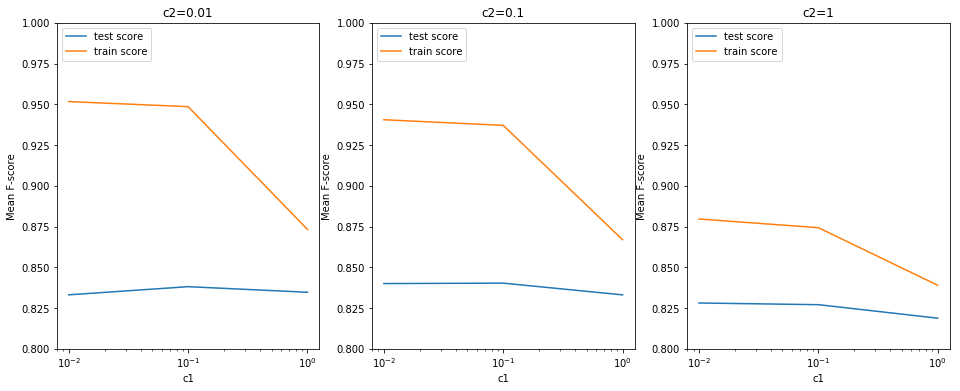

In [24]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [25]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_features, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [26]:
# make predictions 
y_pred = crf.predict(X_test_features)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

       B-tim      0.934     0.868     0.900      6109
       B-org      0.793     0.735     0.763      5896
       I-org      0.817     0.800     0.808      4988
       B-geo      0.856     0.907     0.881     11488
       B-per      0.853     0.825     0.839      5141
       I-per      0.852     0.906     0.878      5201
       B-gpe      0.975     0.921     0.948      4787
       I-tim      0.838     0.736     0.783      2031
       I-geo      0.832     0.798     0.815      2236
       I-gpe      0.868     0.524     0.653        63
       B-eve      0.500     0.300     0.375        90
       B-art      0.406     0.104     0.166       125
       I-art      0.074     0.022     0.034        90
       B-nat      0.667     0.243     0.356        74
       I-nat      0.333     0.100     0.154        20
       I-eve      0.383     0.228     0.286        79

   micro avg      0.861     0.843     0.852     48418
   macro avg      0.686   